In [6]:
import os
import sys
os.environ["METIS_DLL"] = "/opt/homebrew/Cellar/metis/5.1.0/lib/libmetis.dylib"
os.environ["DATASET_DIR"] = os.path.abspath("../../datasets")
if os.path.abspath("../python") not in sys.path:
    sys.path.append(os.path.abspath("../python"))
import pandas as pd
import numpy as np
import string
import random
from scipy.io import loadmat
import matplotlib.pyplot as plt
import metis
import collections
from datasets import EdgeListDataset, DGraphFin

# Sx-Superuser

In [3]:
a = EdgeListDataset(folder_name="sx-superuser", file_name="sx-superuser", extension="tsv", sep="\t")

In [8]:
a.partition(19)


Partitioned to 19 partitions with cut 209152 and RF 1.5550557745317772


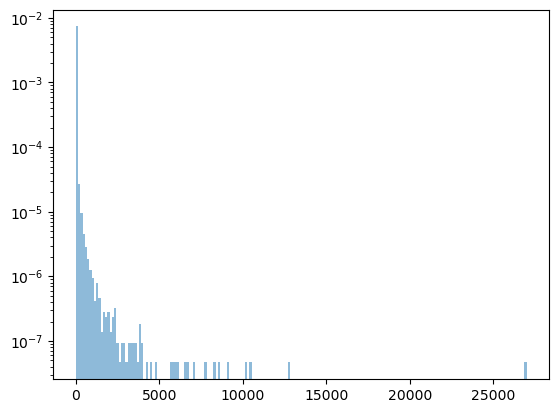

In [27]:
a.plot_degree(log=True)

# Reddit-Hyperlink

In [3]:
reddit = EdgeListDataset(folder_name="RedditHyperlinks", file_name="soc-redditHyperlinks-body", extension="tsv", sep="\t")

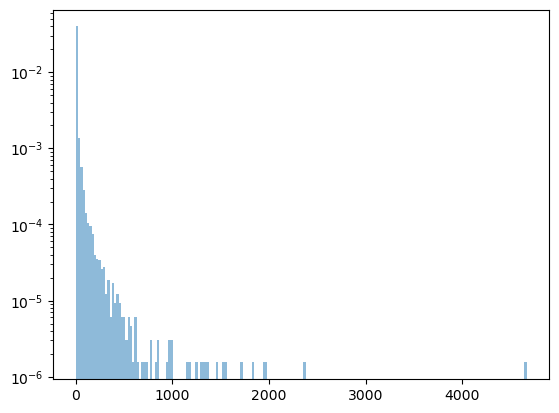

In [5]:
reddit.plot_degree(log=True)

# DGraphFin

In [18]:
fin = DGraphFin("DGraphFin", "dgraphfin")

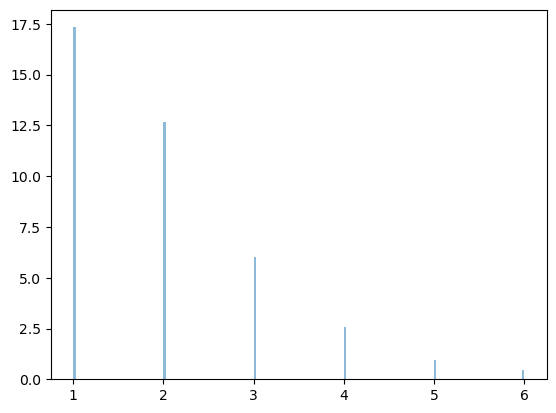

In [19]:
fin.plot_degree()